In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras import layers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 500

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [3]:
# Load test data
test = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [4]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [5]:
# Load MobileNet and freeze weights
keras.backend.clear_session()

mobilenet = MobileNetV3Large(include_top=False)
mobilenet.trainable = False

In [6]:
# Build classifier around MobileNet
input = keras.Input(shape=(img_height, img_width, 3))
x = mobilenet(input, training=False)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=1024, activation="relu")(x)
output = layers.Dense(units=1, activation="sigmoid")(x)

model = Model(inputs=input, outputs=output)

In [7]:
# Compile model
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [8]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         Y          
                                                                            
 MobilenetV3large (Functiona  (None, None, None, 960)  2996352   N          
 l)                                                                         
                                                                            
 flatten (Flatten)           (None, 960)               0         Y          
                                                                            
 dropout (Dropout)           (None, 960)               0         Y          
                                                                            
 dense (Dense)               (None, 1024)              984064    Y          
                                                             

In [9]:
# Train classifier
epochs = 4

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0)

history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.572607,0.714325,0.715870,0.710391,0.488622,0.77200,0.788533,0.744284
1,0.527369,0.737975,0.742177,0.728998,0.479723,0.78140,0.794551,0.759960
2,0.508647,0.749862,0.755213,0.739102,0.476005,0.78685,0.803376,0.760459
3,0.496032,0.757975,0.761428,0.751107,0.471779,0.78745,0.815939,0.743185


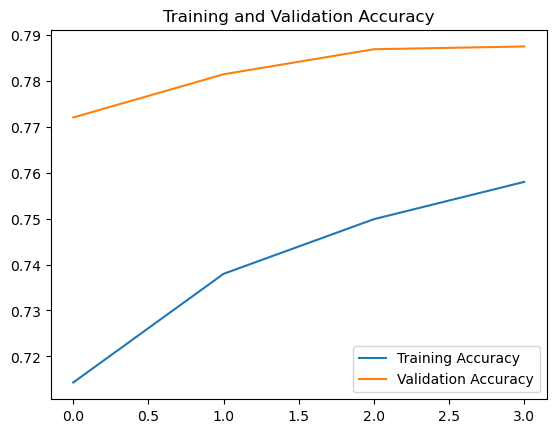

In [10]:
# Plot training and validation accuracy
plt.plot(range(epochs), history["accuracy"], label="Training Accuracy")
plt.plot(range(epochs), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [11]:
# Unfreeze MobileNet
mobilenet.trainable = True

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         Y          
                                                                            
 MobilenetV3large (Functiona  (None, None, None, 960)  2996352   Y          
 l)                                                                         
                                                                            
 flatten (Flatten)           (None, 960)               0         Y          
                                                                            
 dropout (Dropout)           (None, 960)               0         Y          
                                                                            
 dense (Dense)               (None, 1024)              984064    Y          
                                                             

In [12]:
# Recompile model with low learning rate
model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(1e-4),
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [13]:
# Early stopping
es = EarlyStopping(monitor="val_accuracy",
                   patience=10,
                   restore_best_weights=True,
                   verbose=1)

In [14]:
# Fine-tune model
epochs = 60

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0,
  callbacks=es)

history = pd.DataFrame(history.history)
display(history)

Restoring model weights from the end of the best epoch: 32.
Epoch 42: early stopping


,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.260689,0.891350,0.894745,0.886958,0.198043,0.92915,0.929213,0.929306
1,0.160904,0.937038,0.937945,0.935951,0.157135,0.94265,0.945360,0.939790
2,0.129420,0.949987,0.950093,0.949831,0.137106,0.95010,0.952071,0.948078
3,0.104727,0.960500,0.960808,0.960135,0.127837,0.95355,0.961875,0.944683
4,0.085999,0.967725,0.967456,0.967988,0.120176,0.95520,0.961068,0.948977
5,0.074567,0.972650,0.973066,0.972190,0.125755,0.95505,0.968448,0.940889
6,0.057374,0.978675,0.978284,0.979067,0.127327,0.95355,0.967291,0.938991
7,0.047167,0.982463,0.982854,0.982043,0.118294,0.95795,0.952367,0.964254
8,0.033090,0.987800,0.988064,0.987520,0.128038,0.95855,0.955293,0.962257
9,0.028472,0.989613,0.989817,0.989396,0.149702,0.95360,0.934743,0.975437


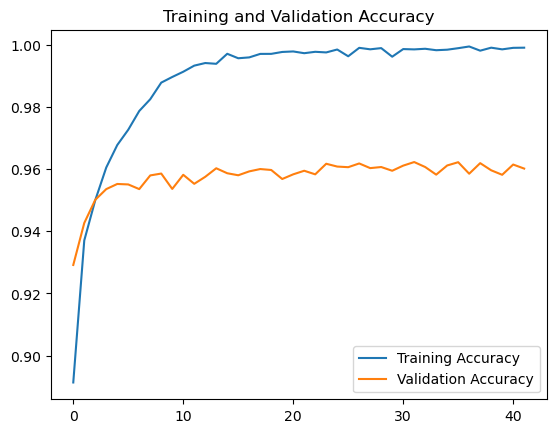

In [16]:
# Plot training and validation accuracy
plt.plot(range(len(history)), history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [17]:
# Evaluate on test data
model.evaluate(test, return_dict=True)

40/40 [==============================] - 6s 121ms/step - loss: 0.1751 - accuracy: 0.9638 - precision: 0.9674 - recall: 0.9600


{'loss': 0.17506107687950134,
 'accuracy': 0.9638000130653381,
 'precision': 0.9673518538475037,
 'recall': 0.9599999785423279}

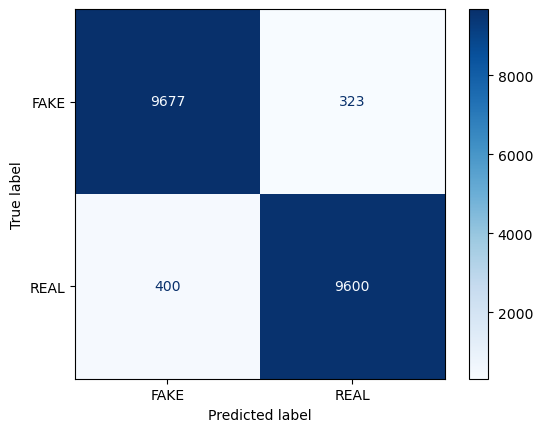

In [18]:
# Confusion matrix
test_predictions = np.array([])
test_labels = np.array([])
for x, y in test:
    test_predictions = np.append(test_predictions, model(x) > 0.5)
    test_labels = np.append(test_labels, y)
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=classes, cmap="Blues");